# Entendendo o que é um parâmetro

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
    media = results['test_score'].mean() * 100
    desvio = results['test_score'].std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
    

In [8]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [15]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)

results = cross_validate(modelo, 
                         x_azar, 
                         y_azar, 
                         cv = cv, 
                         groups = dados.modelo, 
                         return_train_score=False)

imprime_resultados(results)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


In [ ]:
!pip install graphviz

In [ ]:
!pip install pydot

In [16]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, 
                           out_file=None, 
                           filled=True, 
                           rounded=True, 
                           class_names=['não', 'sim'], 
                           feature_names=features)


# Quanto mais complexa a árvore, melhor?

## Explorando hiper parâmetros em 1D

In [46]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
    
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)

    results = cross_validate(modelo, 
                             x_azar, 
                             y_azar, 
                             cv = cv, 
                             groups = dados.modelo, 
                             return_train_score=True)
    test_score = results['test_score'].mean()*100
    train_score = results['train_score'].mean()*100

    #print(f"Arvore max_depth = {max_depth}, treino = {train_score}, média = {test_score}")
    
    tabela = [max_depth, train_score, test_score]
    
    return tabela
    

In [47]:
resultados = [roda_arvore_de_decisao(i) for i in range(1, 33)]

In [49]:
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'train', 'test'])

In [50]:
resultados.head()

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


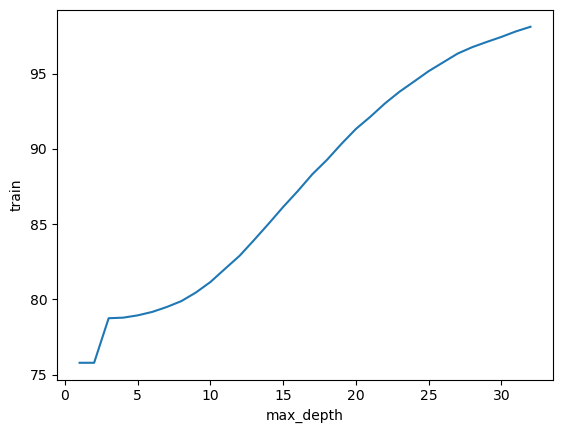

In [52]:
import seaborn as sns

sns.lineplot(x = 'max_depth', y = 'train', data=resultados);

# OverFit dos dados

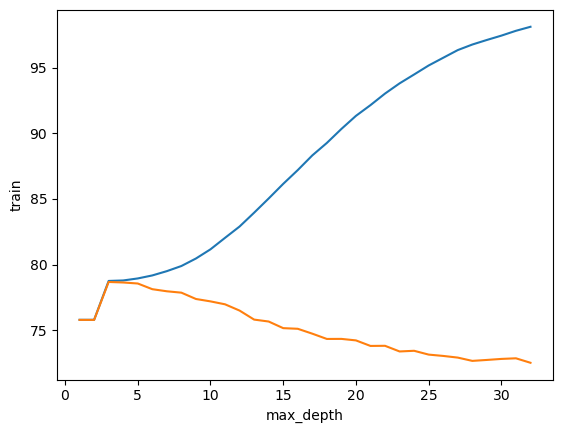

In [53]:
sns.lineplot(x = 'max_depth', y = 'train', data=resultados);
sns.lineplot(x = 'max_depth', y = 'test', data=resultados);

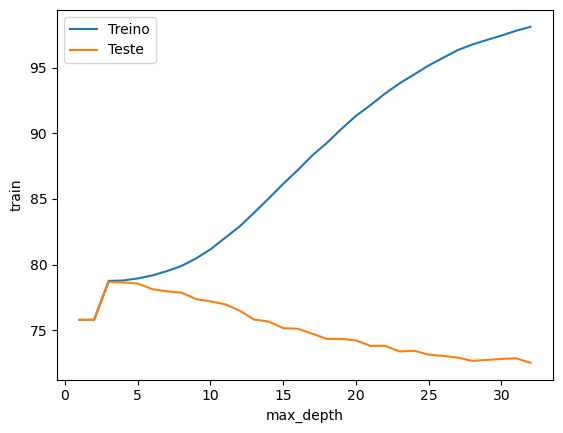

In [55]:
import matplotlib.pyplot as plt

sns.lineplot(x = 'max_depth', y = 'train', data=resultados);
sns.lineplot(x = 'max_depth', y = 'test', data=resultados);
plt.legend(["Treino", "Teste"]);

In [61]:
resultados.sort_values("test", ascending=False).head(10)

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185
7,8,79.887810,77.857951
8,9,80.459009,77.376956
9,10,81.158994,77.194204
10,11,82.032490,76.971552
11,12,82.894797,76.494399


## Explorando hiper parâmetros em 2D

In [62]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth, min_samples_leaf):
    
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, 
                             x_azar, 
                             y_azar, 
                             cv = cv, 
                             groups = dados.modelo, 
                             return_train_score=True)
    test_score = results['test_score'].mean()*100
    train_score = results['train_score'].mean()*100
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    
    return tabela
    

In [63]:
resultados = []
for max_depth in range(1, 33):
    for min_samples_leaf in range(1, 33):
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)

In [65]:
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'train', 'test'])

In [69]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,train,test
123,4,28,78.750993,78.672633
126,4,31,78.750993,78.672633
85,3,22,78.750993,78.672633
84,3,21,78.750993,78.672633
83,3,20,78.750993,78.672633


In [72]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-3.757177e-16,0.681408,-0.522835
min_samples_leaf,-3.757177e-16,1.000000e+00,-0.453825,0.528330
train,6.814075e-01,-4.538248e-01,1.000000,-0.762534
test,-5.228349e-01,5.283299e-01,-0.762534,1.000000


* Dada a **correlação** de dois valores, significa que quanto mais um valor cresce, outro cresce também. Ou seja, se isso acontece, significa que ambos são mais relacionados.

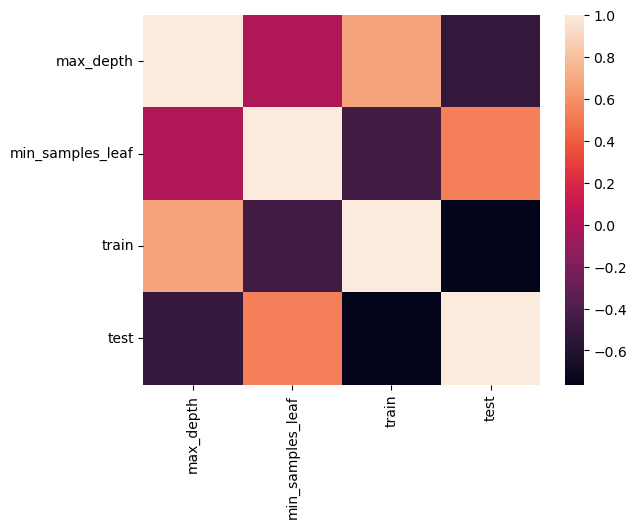

In [74]:
sns.heatmap(corr);

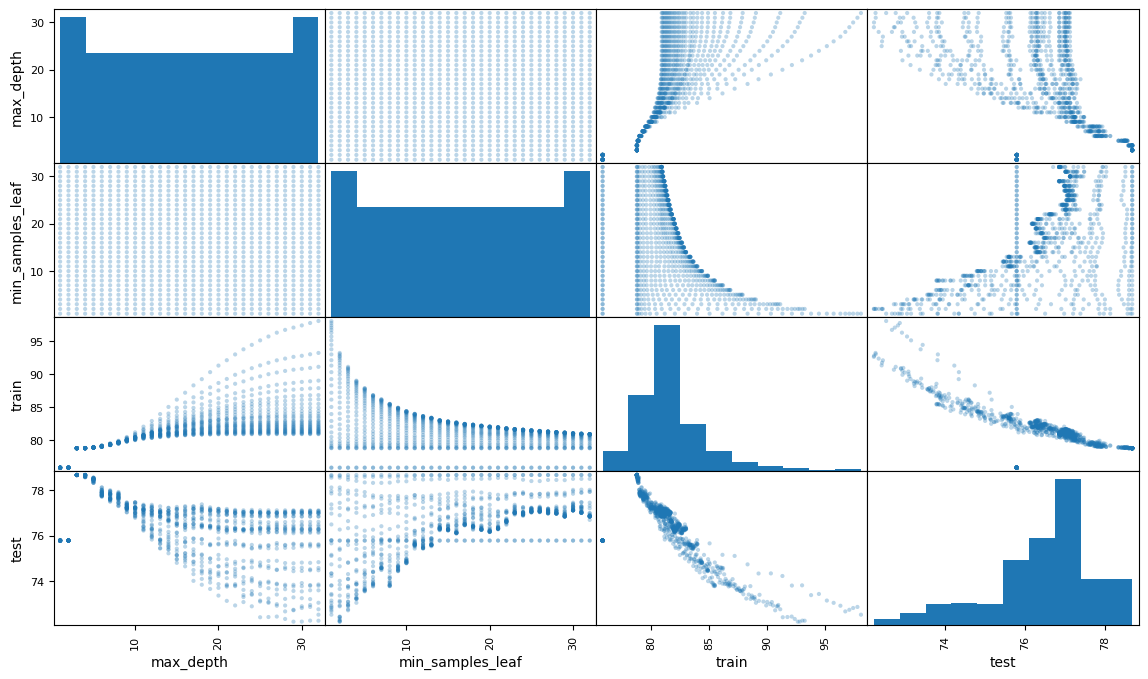

In [80]:
from pandas.plotting import scatter_matrix

scatter_matrix(resultados, figsize = (14, 8), alpha=0.3);

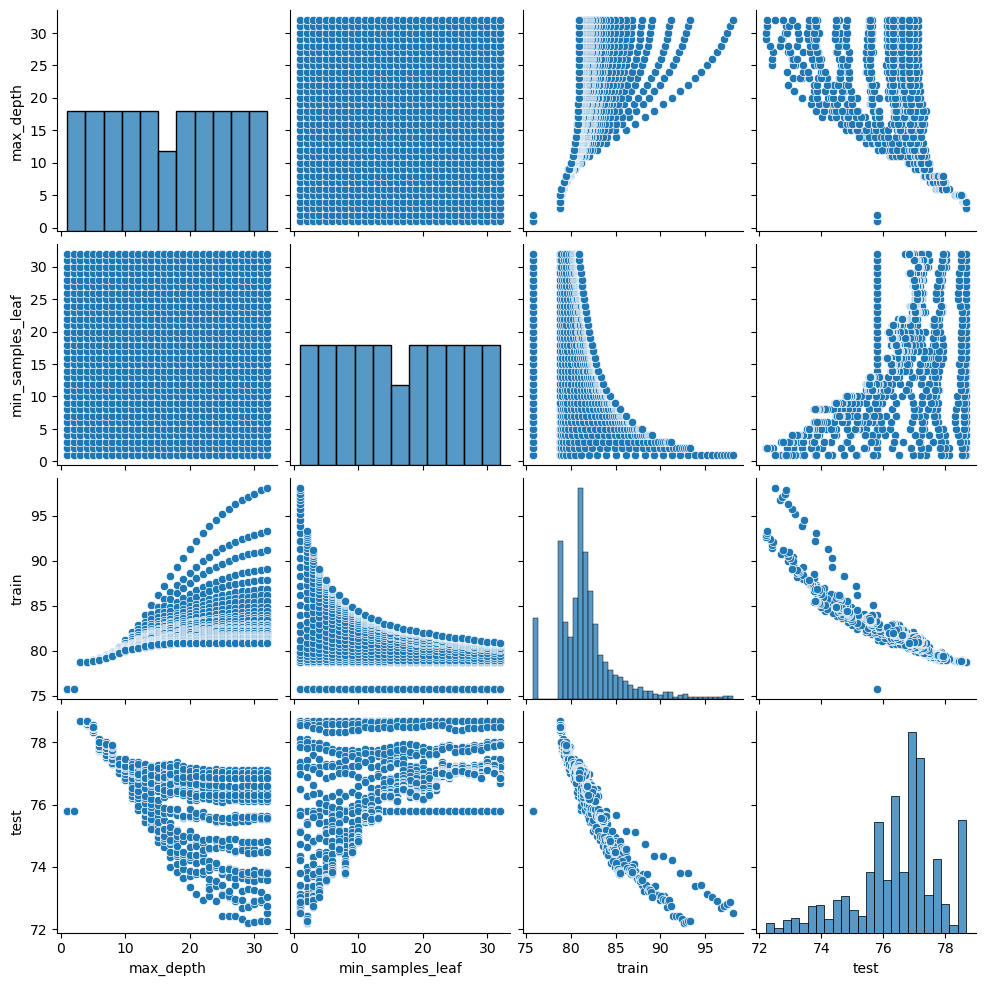

In [82]:
sns.pairplot(resultados);

C:\Users\TTMENDES\AppData\Local\Temp\ipykernel_7016\3792064364.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

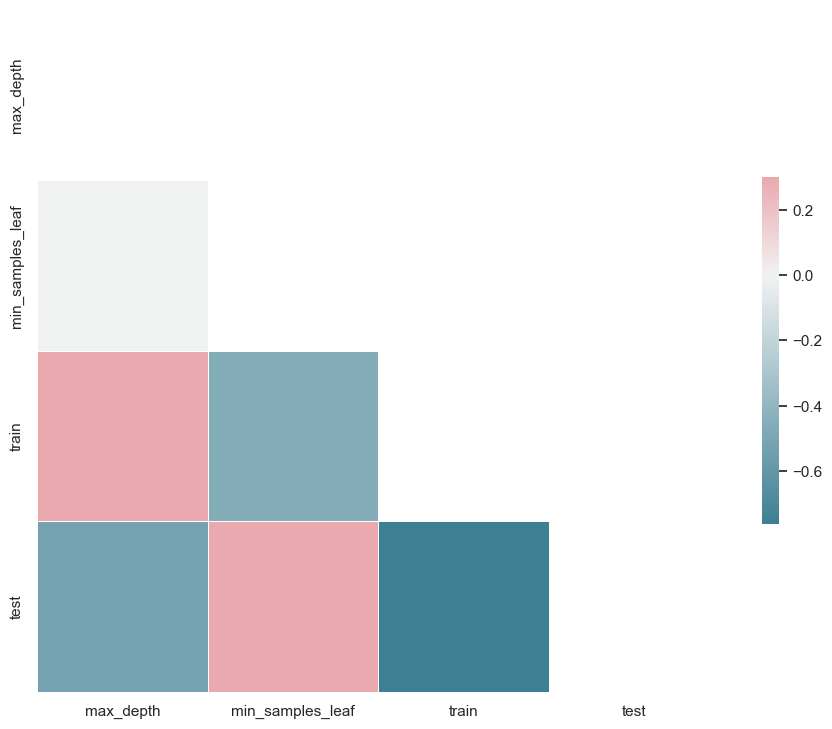

In [83]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Explorando 3 ou mais parâmetros

In [85]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100

    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test"])
    return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test
0,1,32,32,75.791169,75.784219
1,1,32,64,75.791169,75.784219
2,1,32,128,75.791169,75.784219
3,1,32,256,75.791169,75.784219
4,1,64,32,75.791169,75.784219


In [86]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test
max_depth,1.000000e+00,1.300685e-16,4.182375e-16,0.529391,0.011529
min_samples_leaf,1.300685e-16,1.000000e+00,0.000000e+00,-0.341222,0.286555
min_samples_split,4.182375e-16,0.000000e+00,1.000000e+00,-0.126171,0.132827
train,5.293913e-01,-3.412220e-01,-1.261715e-01,1.000000,0.247850
test,1.152853e-02,2.865546e-01,1.328271e-01,0.247850,1.000000


C:\Users\TTMENDES\AppData\Local\Temp\ipykernel_7016\1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

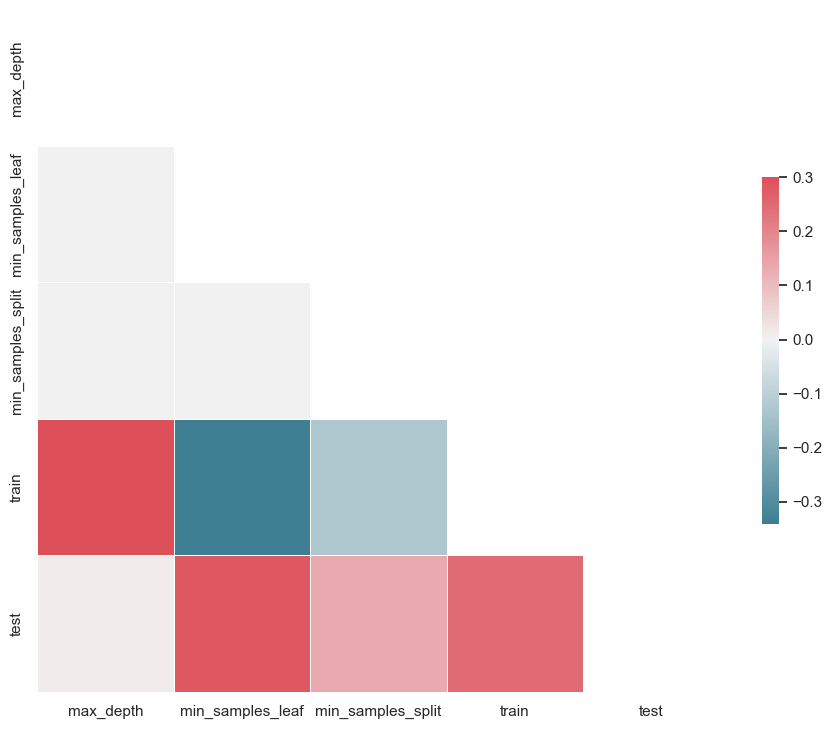

In [87]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [88]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test
63,4,256,256,78.750993,78.672633
48,4,32,32,78.750993,78.672633
34,3,32,128,78.750993,78.672633
35,3,32,256,78.750993,78.672633
36,3,64,32,78.750993,78.672633


In [89]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    
    train_score = results['train_score'].mean() * 100
    test_score = results['test_score'].mean() * 100
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabela

def busca():
    resultados = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
    return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.007280,0.002103
1,1,32,64,75.791169,75.784219,0.005794,0.001501
2,1,32,128,75.791169,75.784219,0.006062,0.001609
3,1,32,256,75.791169,75.784219,0.006642,0.001861
4,1,64,32,75.791169,75.784219,0.005602,0.001801


In [90]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000e+00,1.300685e-16,4.182375e-16,0.529391,0.011529,0.467554,-0.188926
min_samples_leaf,1.300685e-16,1.000000e+00,0.000000e+00,-0.341222,0.286555,-0.522300,-0.133935
min_samples_split,4.182375e-16,0.000000e+00,1.000000e+00,-0.126171,0.132827,-0.052767,0.099301
train,5.293913e-01,-3.412220e-01,-1.261715e-01,1.000000,0.247850,0.884928,0.096924
test,1.152853e-02,2.865546e-01,1.328271e-01,0.247850,1.000000,-0.000506,0.009571
fit_time,4.675536e-01,-5.222999e-01,-5.276662e-02,0.884928,-0.000506,1.000000,0.184807
score_time,-1.889259e-01,-1.339352e-01,9.930149e-02,0.096924,0.009571,0.184807,1.000000


C:\Users\TTMENDES\AppData\Local\Temp\ipykernel_7016\1569857682.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

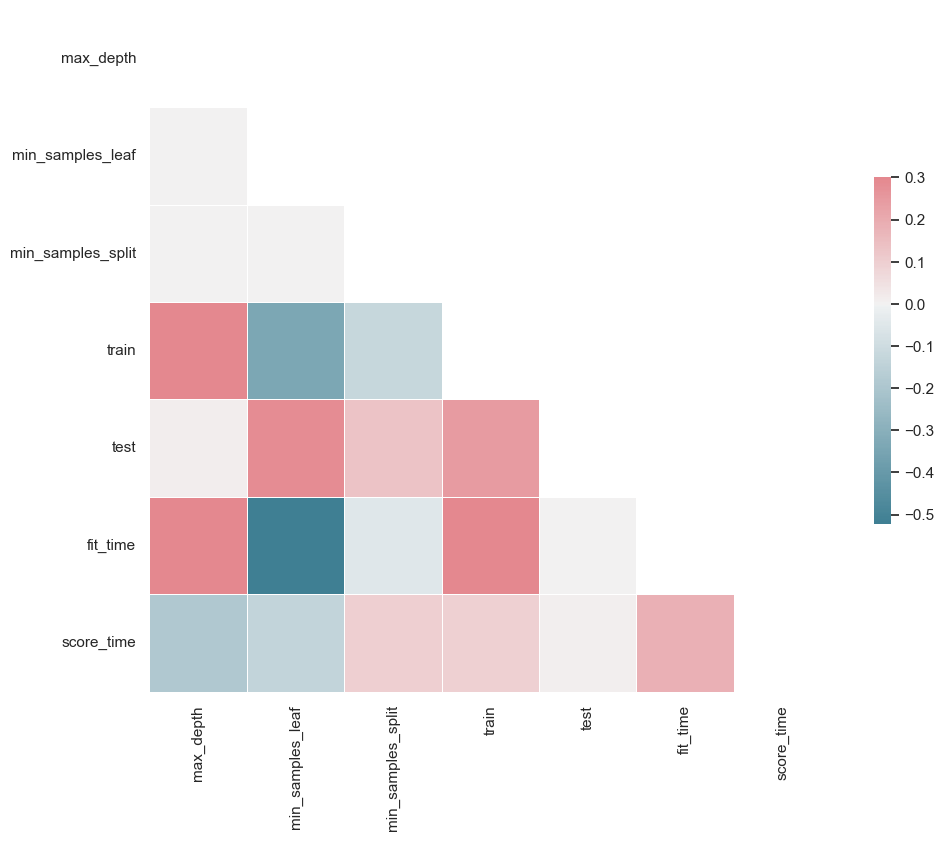

In [91]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [92]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.011945,0.001944
48,4,32,32,78.750993,78.672633,0.013291,0.001601
34,3,32,128,78.750993,78.672633,0.010199,0.001802
35,3,32,256,78.750993,78.672633,0.010168,0.001605
36,3,64,32,78.750993,78.672633,0.010209,0.001586


# Explorando espaços de hiper parâmetros com GridSearchCV

In [93]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {"max_depth" : [3, 5],
                        "min_samples_split": [32, 64, 128],
                        "min_samples_leaf": [32, 64, 128],
                        "criterion": ["gini", "entropy"] 
                       }

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010456,0.001011,0.001984,0.000448,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.009702,0.000644,0.001499,0.000502,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.009707,0.000467,0.001791,0.000397,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.009898,0.000299,0.001602,0.000490,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.009911,0.000538,0.001693,0.000454,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [94]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [95]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [96]:
from sklearn.metrics import accuracy_score 

predicoes = melhor.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


## Nested cross validation e validando o melhor modelo

* No caso de **Cross Validation** com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se **nested cross validation**.

In [97]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

C:\Users\TTMENDES\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\TTMENDES\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\TTMENDES\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\TTMENDES\anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
                        "max_depth" : [3, 5],
                        "min_samples_split": [32, 64, 128],
                        "min_samples_leaf": [32, 64, 128],
                        "criterion": ["gini", "entropy"]
                        }

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009599,0.000800,0.001402,0.000490,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.010554,0.001149,0.002209,0.000753,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.008571,0.000403,0.001676,0.000441,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.008528,0.000442,0.002034,0.000039,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.008643,0.000856,0.001947,0.000255,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [99]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [100]:
def imprime_score(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))
    

In [102]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
